In [ ]:
!pip install keras
!pip install numpy
!pip install pandas
!pip install tensorflow
!pip install json
!pip install tensorflow_io
!pip install tensorflow-gpu

ERROR: Could not find a version that satisfies the requirement json (from versions: none)
ERROR: No matching distribution found for json
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 12.8 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import shutil
import random
import numpy as np
import json
import zipfile
import os
import pandas as pd
import PIL
import os
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tqdm import tqdm
from keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Dense, Flatten
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import lime
# from lime import lime_image
from PIL import Image

from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
print("GPU Available? - ", len(tf.config.experimental.list_physical_devices('GPU')))


Mounted at /content/drive
GPU Available? -  1


In [ ]:
# Extract images from ZIP and store in drive
# Use custom images_small_jpg.zip - extraction time +/- 5 minutes
dataset_path = '/content/drive/MyDrive/dataset.json'
# zip_path = '/content/drive/MyDrive/images-small.zip'
zip_path = '/content/drive/MyDrive/images_small_jpg.zip'
images_path = '/content/jpg'

# Check if the extraction directory already exists
if not os.path.exists(images_path):
    os.mkdir(images_path)
# Extract zip file store it on disk (this will be deleted after runtime ends. Extracting is always needed.)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(images_path)
print("Zip file extracted successfully.")

Zip file extracted successfully.


{0: '0-99', 100: '100-199', 200: '200-299', 300: '300-399', 400: '400-499', 500: '500-599', 600: '600-699', 700: '700-799', 800: '800-899', 900: '900-999', 1000: '1000-1099', 1100: '1100-1199', 1200: '1200-1299', 1300: '1300-1399', 1400: '1400-1499', 1500: '1500-1599', 1600: '1600-1699', 1700: '1700-1799', 1800: '1800-1899', 1900: '1900-1999', 2000: '2000-2099', 2100: '2100-2199'}
outlier ignored
outlier ignored
outlier ignored
outlier ignored
outlier ignored
outlier ignored
outlier ignored
outlier ignored
outlier ignored
outlier ignored
outlier ignored
outlier ignored
outlier ignored
outlier ignored
outlier ignored
outlier ignored
outlier ignored
outlier ignored
outlier ignored
outlier ignored
outlier ignored
outlier ignored
outlier ignored
outlier ignored
outlier ignored
outlier ignored
outlier ignored
outlier ignored
outlier ignored
outlier ignored
outlier ignored
outlier ignored
outlier ignored
outlier ignored
outlier ignored
outlier ignored
outlier ignored
outlier ignored
outlier 

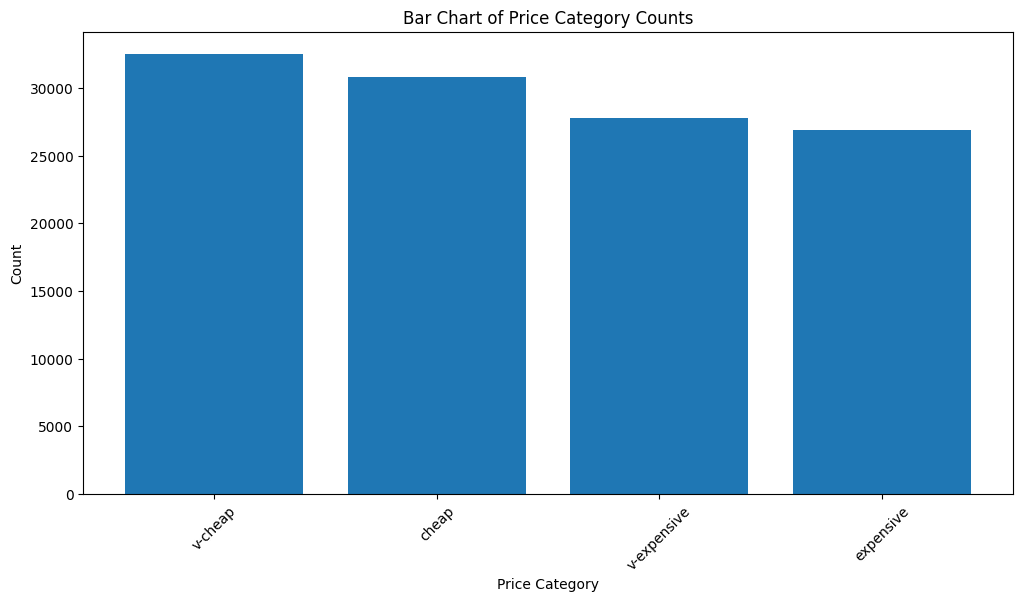

price: v-expensive - id: 2805630_ss_02b69bffacf19807fb6202fb8167fad7e08eae77.1920x1080.jpg
price: v-expensive - id: 2805630_ss_67edf620e44492c0110912c2a6672113011aa94c.1920x1080.jpg
price: v-expensive - id: 2805630_ss_790259f92a9ba5f506a00eafc9efa4fb2dc9686d.1920x1080.jpg
price: v-expensive - id: 2805630_ss_a25f2dcb34e2688eaa6c9a971c38a03dbdab18fb.1920x1080.jpg
price: v-expensive - id: 2805630_ss_b8fb2eff1ddc2816f0ec744d467ab3dfe9d584e1.1920x1080.jpg
price: v-expensive - id: 2805630_ss_c1a17e1b1ca267e911de2948f426b34b07cca172.1920x1080.jpg
price: v-expensive - id: 2805630_ss_c96c5067160ab0a5eeb71142478872313ee4d234.1920x1080.jpg
price: v-expensive - id: 2805630_ss_fc7976bb6906578e962c52d4952a5b4184351d1c.1920x1080.jpg
price: v-cheap - id: 2805610_ss_21f5dfd4d369f1cefdd9d233f574a4758dba8793.1920x1080.jpg
price: v-cheap - id: 2805610_ss_2f7441f3175b1109dd3d808108203bf6911a9e8d.1920x1080.jpg
.....


In [ ]:
import matplotlib.pyplot as plt
import math

# Set to True for 22 categories (0-99, 100-199, ...)
# Set to False for 4 categories (very cheap-cheap-expensive-very expensive)
use_22_cats = False


with open(dataset_path, "r") as f:
    data = json.load(f)
prices_id = {}
screenshot_ids = []
all_prices_list = []
for item in data:
    # Check if 'price_category' key is present in the 'item' dictionary
    if item['price'] is not None:
        # Extract the price category
        price = item['price']
        all_prices_list.append(price)

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = np.percentile(all_prices_list, 25)
Q2 = np.percentile(all_prices_list, 50)
Q3 = np.percentile(all_prices_list, 75)
Q4 = np.percentile(all_prices_list, 100)
IQR = Q3 - Q1

# Define the outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

price_cats = dict()
x = 0
# Use for 22 categories...
while x <= upper_bound:
  price_cats[x]=f'{x}-{x+99}'
  x += 100
print(price_cats)

if not use_22_cats:
  price_cats = {int(Q1): 'v-cheap', int(Q2): 'cheap', int(Q3): 'expensive', int(Q4): 'v-expensive'}

for item in data:
    # Check if 'price_category' key is present in the 'item' dictionary
    if item['price'] is not None:
        # Extract the price category
        price = item['price']
        if price > upper_bound:
          print("outlier ignored")
          continue
        rounded_price = math.floor(price / 100) * 100

        # Extract the image IDs from the "full_images" list and map them to their price category
        if lower_bound <= price <= upper_bound:
          for screenshot in item["screenshots"]:
              screenshot_id = screenshot
              screenshot_ids.append(screenshot_id)
              if use_22_cats:
                prices_id[screenshot_id] = price_cats[rounded_price]
              else:
                selected_key = None
                for key in reversed(price_cats.keys()):
                  if price <= int(key):
                    selected_key = key
                  else:
                    break
                if selected_key == None:
                  selected_key = Q4
                prices_id[screenshot_id] = price_cats[selected_key]

price_counts = pd.Series(prices_id.values()).value_counts()
downsample_value = 1 * price_counts.mean()
if not use_22_cats:
  # downsample to min to get all categries of equal size
  downsample_value = price_counts.min()
print(downsample_value)
# Create a DataFrame from the value counts
df_counts = pd.DataFrame({'Price_Category': price_counts.index, 'Count': price_counts.values})

# Plotting the bar chart
plt.figure(figsize=(12, 6))
plt.bar(df_counts['Price_Category'], df_counts['Count'])
plt.title('Bar Chart of Price Category Counts')
plt.xlabel('Price Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


# prices = sorted(filtered_data.values())
# # Define the bin edges
# max_price = max(prices)
# bins = np.arange(0, max_price + 100, 100)

# # Count the prices in each bin
# hist, bin_edges = np.histogram(prices, bins=bins)

# # Plot the data
# plt.bar(bin_edges[:-1], hist, width=10, edgecolor='black')

# # Label the plot
# plt.xlabel('Price Range')
# plt.ylabel('Number of Prices')
# plt.title('Distribution of Prices in Blocks of 10')
# plt.xticks(bin_edges)

# # Display the plot
# plt.show()

examples = 0
for id, price in prices_id.items():
  print(f'price: {price} - id: {id}')
  examples += 1
  if examples >= 10:
    print('.....')
    break

                                                  id      label
0  2100390_ss_7acc9ce0d5967e71ecd4e1275b2b67bd4a8...  expensive
1  2514960_ss_37fc204dce9127beb43af48ee052951d96f...  expensive
2  1701890_ss_ae716d1bd6a59c31562856382f1ff502e54...  expensive
3  2276960_ss_2f41a20101a1c4ff26ba05db063c9785885...      cheap
4  2389890_ss_210e6a22f59959ae32cfdc65f53f1c484b9...      cheap
26881


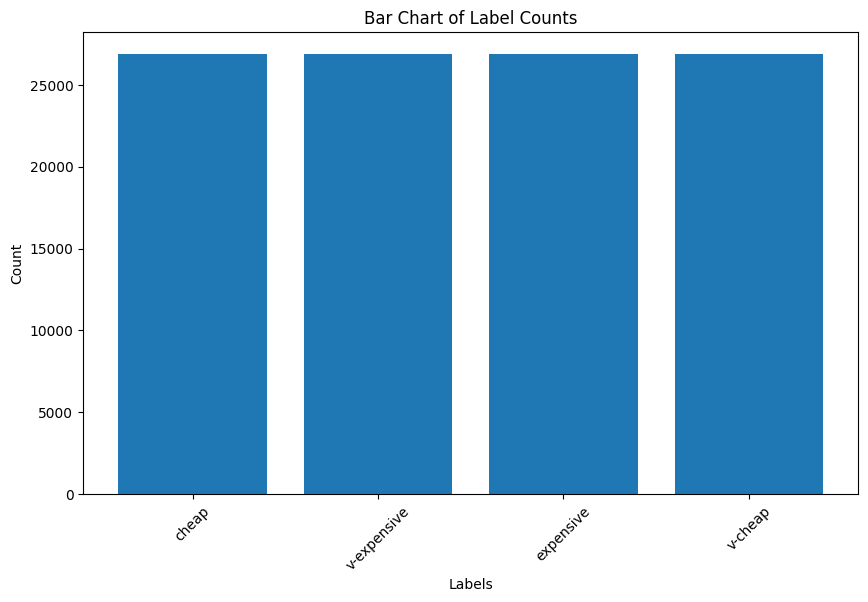

In [ ]:
import random
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.utils import resample
images_path = '/content/jpg/images_jpg'
train_set_path = '/content/train/'
validation_set_path = '/content/validation/'
test_set_path = '/content/test/'

try:
  os.mkdir(train_set_path)
  os.mkdir(validation_set_path)
  os.mkdir(test_set_path)
except:
  print("files exist")

use_small = False # Set to True for testing and troubleshooting to spare resources

if use_small:
  train_split = 0.07
  val_split = 0.015
  test_split = 0.015
else:
  train_split = 0.7
  val_split = 0.15
  test_split = 0.15


random.seed(42) # random seed (42 - the answer to the ultimate question of life the universe and everything ;) )
random.shuffle(screenshot_ids)  # shuffle image id's

total_data_df = pd.DataFrame({'id': screenshot_ids, "label": [prices_id[scr_shot_id] for scr_shot_id in screenshot_ids]})
print(total_data_df.head())

# Define the number of samples you want to downsample to for each class
desired_samples = int(round(downsample_value))  # Adjust as needed
print(desired_samples)
# Perform downsampling for each class
downsampled_data = []
for label_class in total_data_df['label'].unique():
    # Select data points belonging to the current class
    class_data = total_data_df[total_data_df['label'] == label_class]

    # Downsample the class to the desired number of samples
    if len(class_data) >= desired_samples:
      downsampled_class = resample(class_data, replace=False, n_samples=desired_samples, random_state=42)
    else:
      downsampled_class = class_data
    # Add the downsampled class to the list
    downsampled_data.append(downsampled_class)

# Concatenate the downsampled classes into a single DataFrame
downsampled_df = pd.concat(downsampled_data)

# Shuffle the downsampled DataFrame
total_data_df = downsampled_df.sample(frac=1, random_state=42).reset_index(drop=True)
label_counts = total_data_df['label'].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Bar Chart of Label Counts')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
plt.show()

train_df, temp_data = train_test_split(total_data_df, test_size=(1 - train_split), random_state=42)

# Now, split the temporary set into validation and test sets
val_size = val_split / (val_split + test_split)  # Adjust the validation size to the proportion of the temp set
val_df, test_df = train_test_split(temp_data, test_size=(1 - val_size), random_state=42)

# train_screenshot_ids = screenshot_ids[:int(len(screenshot_ids) * train_split)]
# val_screenshot_ids = screenshot_ids[int(len(screenshot_ids) * train_split):int(len(screenshot_ids) * (train_split + val_split))]
# test_screenshot_ids = screenshot_ids[int(len(screenshot_ids) * (train_split + val_split)):int(len(screenshot_ids) * (train_split + val_split + test_split))]
# train_filenames = [f"{scr_shot_id}" for scr_shot_id in train_screenshot_ids]
# val_filenames = [f"{scr_shot_id}" for scr_shot_id in val_screenshot_ids]
# test_filenames = [f"{scr_shot_id}" for scr_shot_id in test_screenshot_ids]
train_filenames = train_df['id'].tolist()
val_filenames = val_df['id'].tolist()
test_filenames = test_df['id'].tolist()

In [ ]:
import pandas as pd
from sklearn.utils import resample
# train_df_b = pd.DataFrame(
# {"id": train_filenames, "label": [prices_id[scr_shot_id] for scr_shot_id in train_screenshot_ids]})
# train_df_b = pd.DataFrame({"id": train_filenames, "label": [prices_id[scr_shot_id] for scr_shot_id in train_screenshot_ids]})


# val_df = pd.DataFrame(
#     {"id": val_filenames, "label": [prices_id[scr_shot_id] for scr_shot_id in val_screenshot_ids]})
# test_df = pd.DataFrame(
#     {"id": test_filenames, "label": [prices_id[scr_shot_id] for scr_shot_id in test_screenshot_ids]})
# print(train_df.head())

In [ ]:
from PIL import Image

def is_image_corrupted(image_path):
    try:
        Image.open(image_path)
        return False
    except (IOError, SyntaxError) as e:
      # print(e)
      return True

In [ ]:
# execution time for large: approx 4 min (je pense)
# execution time for small: 1 (idk - tis ni lang)
corrupted_count = 0
for filename in train_filenames:
    src_path = os.path.join(images_path, filename)
    dst_path = os.path.join(train_set_path, filename)
    is_corrupted = is_image_corrupted(src_path)
    if is_corrupted:
        #print(f"corrupted image: {filename}")
        corrupted_count += 1
    else:
        shutil.move(src_path, dst_path)
print(f'corrupted or missing files in train set: {corrupted_count}')

corrupted_count = 0
for filename in val_filenames:
    src_path = os.path.join(images_path, filename)
    dst_path = os.path.join(validation_set_path, filename)
    is_corrupted = is_image_corrupted(src_path)
    if is_corrupted:
        # print(f"corrupted image: {filename}")
        corrupted_count += 1
    else:
        shutil.move(src_path, dst_path)
print(f'corrupted or missing files in val set: {corrupted_count}')

corrupted_count = 0
for filename in test_filenames:
    src_path = os.path.join(images_path, filename)
    dst_path = os.path.join(test_set_path, filename)
    is_corrupted = is_image_corrupted(src_path)
    if is_corrupted:
        # print(f"corrupted image: {filename}")
        corrupted_count += 1
    else:
        shutil.move(src_path, dst_path)
print(f'corrupted or missing files in test set: {corrupted_count}')


corrupted or missing files in train set: 2
corrupted or missing files in val set: 0
corrupted or missing files in test set: 1


In [ ]:
img_width, img_height = 224, 224
batch_size = 32

In [ ]:
import tensorflow_io as tfio
# Build generators, without all data should be loaded in RAM. This is not possible so we use a generator
train_datagen = ImageDataGenerator(rescale=1. / 255, rotation_range=20, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
        dataframe = train_df,
        directory='/content/train',
        target_size=(224,224),
        x_col="id",
        y_col="label",
        seed=42,
        shuffle=True,
        class_mode="categorical",
        batch_size=32)

validation_generator = val_datagen.flow_from_dataframe(
        dataframe = val_df,
        directory='/content/validation',
        target_size=(224,224),
        x_col="id",
        y_col="label",
        seed=42,
        shuffle=True,
        class_mode="categorical",
        batch_size=32)

test_generator = test_datagen.flow_from_dataframe(
        dataframe = test_df,
        directory='/content/test',
        target_size=(224,224),
        x_col="id",
        y_col="label",
        seed=42,
        shuffle=False,
        class_mode="categorical",
        batch_size=32)

Found 75264 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(


Found 16129 validated image filenames belonging to 4 classes.
Found 16128 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(


#Model:

In [ ]:
# Experiment with setup. This one is from an internet example. Activation function i would keep at relu or leaky relu or gelu
# Final function should be linear for regression (i think)
# Before running ANY experiment with GPU. Check in resources tab to see if you have enough estimated processing time!
# It might be an idea to implement a save model after every epoch but this will take up a lot of space in drive so only if absolutly necessary
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
num_classes = len(price_cats.keys())
model.add(Dense(num_classes, activation='softmax')) #softmax for multiclass, linear for regression

# ALternative architecture to be tested
# model = Sequential()

# # Convolutional layers
# model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)))
# model.add(MaxPooling2D((2, 2)))

# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2, 2)))

# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2, 2)))

# # Flatten layer
# model.add(Flatten())

# # Dense layers
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))  # Adding dropout for regularization

# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))  # Adding dropout for regularization

# model.add(Dense(1, activation='linear'))  # Output layer for regression

In [ ]:
# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Train for two epochs check progress between epoch 1 and 2 to have an idea about model effectivness
history = model.fit(train_generator, steps_per_epoch=len(train_generator), epochs=1, validation_data=validation_generator, validation_steps=len(validation_generator))

2352/2352 [==============================] - 1613s 686ms/step - loss: 1.3633 - accuracy: 0.3083 - val_loss: 1.3813 - val_accuracy: 0.2937


In [ ]:
#test_loss, test_acc = model.evaluate_generator(test_generator, steps=len(test_generator.samples))
#print('Test accuracy:', test_acc)
#print('Test loss:', test_loss)
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

429/429 [==============================] - 108s 251ms/step - loss: 2.8019 - accuracy: 0.0888
Test accuracy: 0.08882730454206467
Test loss: 2.8019423484802246


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

# Generate predictions
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels from the generator
true_labels = test_generator.classes


In [ ]:
def visualize_predictions(generator, model, num_images=10):
    # Get class indices from the generator
    class_indices = generator.class_indices
    # Create a reverse mapping from indices to class names
    idx_to_class = {v: k for k, v in class_indices.items()}
    print(idx_to_class)
    # Get a batch of images and labels
    images, labels = next(generator)
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)

    plt.figure(figsize=(60, 4))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        # print(labels[i])
        index_of_labels_array = np.where(labels[i] == 1)[0][0]
        true_label_name = idx_to_class[index_of_labels_array]
        pred_label_name = idx_to_class[predicted_labels[i]]
        plt.title(f"True: {true_label_name}\nPred: {pred_label_name}")
        plt.axis('off')
    plt.show()

# Visualize predictions
visualize_predictions(test_generator, model, num_images=30)

{0: 'cheap', 1: 'expensive', 2: 'v-cheap', 3: 'v-expensive'}
1/1 [==============================] - 0s 31ms/step


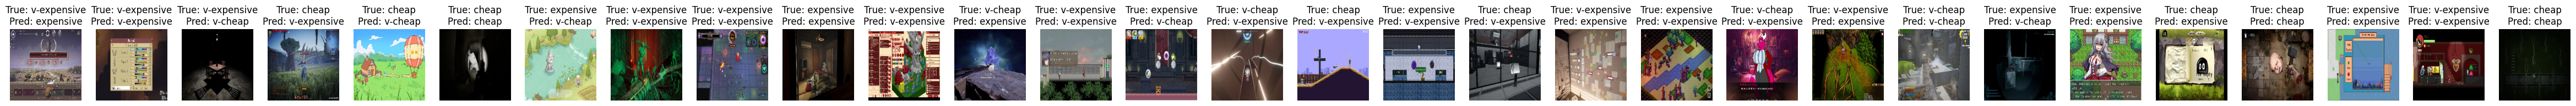

In [ ]:
def visualize_predictions(generator, model, num_images=10):
    # Get class indices from the generator
    class_indices = generator.class_indices
    # Create a reverse mapping from indices to class names
    idx_to_class = {v: k for k, v in class_indices.items()}
    print(idx_to_class)
    # Get a batch of images and labels
    images, labels = next(generator)
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)

    plt.figure(figsize=(60, 4))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        # print(labels[i])
        index_of_labels_array = np.where(labels[i] == 1)[0][0]
        true_label_name = idx_to_class[index_of_labels_array]
        pred_label_name = idx_to_class[predicted_labels[i]]
        plt.title(f"True: {true_label_name}\nPred: {pred_label_name}")
        plt.axis('off')
    plt.show()

# Visualize predictions
visualize_predictions(test_generator, model, num_images=30)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

# Generate predictions
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels from the generator
true_labels = test_generator.classes

# Function to visualize predictions
def visualize_predictions(generator, model, num_images=10):
    # Reset the generator to start from the beginning
    generator.reset()

    # Get a batch of images and labels
    images, labels = next(generator)
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)

    for i in range(num_images):
        plt.figure(figsize=(20, 2))
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i].astype('uint8'))  # Ensure images are uint8
        true_label = generator.class_indices.inverse_transform([np.argmax(labels[i])])[0]
        pred_label = generator.class_indices.inverse_transform([predicted_labels[i]])[0]
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis('off')
    plt.show()

# Visualize predictions
visualize_predictions(test_generator, model, num_images=20)


In [ ]:
# keep
# this
# code
# but
# don't
# use
# it
# ;)

# Keep this code block in the file but don't use it unless necessary
raise FileExistsError("The file \'images_small_jpg.zip\' was already created and this code block should not be ran again. Make sure you have a shortcut to the zipfile in \'MyDrive\'")
# Keras library does not support webp (so try and convert to jpg hoping file sizes remain small enoug, or alternative is custom vectorization (which will be a pain in the ass))
# This will take approx 4 hours so let's try working with WEBP
images_path = '/content/images/'
jpg_images_path = '/content/images/images_jpg'
try:
  os.mkdir(jpg_images_path)
except FileExistsError:
  print("Folder already exists")
files = os.listdir(images_path)
total_iterations = len(files)
progress_bar = tqdm(total=total_iterations, desc="Processing")
images = os.listdir(images_path)
for image in images:
  progress_bar.update(1)
  image_jpg = image.replace('.webp', '.jpg')
  # Convert to JPEG
  jpeg_image_path = os.path.join(jpg_images_path, image_jpg)
  if os.path.exists(jpeg_image_path):
    continue
  webp_image_path = os.path.join(images_path, image)
  try:
    webp_image = Image.open(webp_image_path)
  except Exception as e:
    print(e)
  webp_image.convert('RGB').save(jpeg_image_path, 'JPEG')


Processing:  48%|████▊     | 61727/128576 [29:59<25:23, 43.88it/s]

[Errno 21] Is a directory: '/content/images/images_jpg'


Processing: 100%|█████████▉| 128574/128576 [1:04:46<00:00, 31.63it/s]

In [ ]:
# Keep this code block in the file but don't use it unless necessary
raise FileExistsError("The file \'images_small_jpg.zip\' was already created and this code block should not be ran again. Make sure you have a shortcut to the zipfile in \'MyDrive\'")
import zipfile
import os
jpg_images_path = '/content/images/images_jpg'
output_path = 'content/drive/MyDrive/images_small_jpg.zip'

def zip_folder(folder_path, output_path):
    # Create a zip file with write permission
    with zipfile.ZipFile(output_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Walk through all the directories and files in the folder
        #for root, dirs, files in os.walk(folder_path):
        files = os.listdir(jpg_images_path)
        for file in files:
            # Create the complete filepath by joining root with the file name
            file_path = os.path.join(jpg_images_path, file)
            # Add file to the zip file
            # The arcname parameter avoids storing the full path in the zip file
            zipf.write(file_path, arcname=os.path.relpath(file_path, os.path.dirname(folder_path)))

# Specify the path to the directory to be zipped
jpg_images_path = '/content/images/images_jpg'
# Specify the output path for the zip file
zip_output_path = '/content/drive/MyDrive/images_small_jpg.zip'

# Call the function
zip_folder(jpg_images_path, zip_output_path)

print("Folder successfully zipped!")

In [ ]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=test_generator.samples // batch_size)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

In [ ]:
# Failed WEBP custom generator test
# import numpy as np
# import pandas as pd
# import tensorflow as tf
# import tensorflow_io as tfio

# class CustomDataGenerator(tf.keras.utils.Sequence):
#     def __init__(self, dataframe, directory, batch_size=32, target_size=(224, 224), shuffle=True):
#         self.dataframe = dataframe
#         self.directory = directory
#         self.batch_size = batch_size
#         self.target_size = target_size
#         self.shuffle = shuffle
#         self.indexes = np.arange(len(self.dataframe))
#         if self.shuffle:
#             np.random.shuffle(self.indexes)

#     def __len__(self):
#         return len(self.dataframe) // self.batch_size

#     def __getitem__(self, index):
#         batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
#         batch_data = []
#         batch_labels = []

#         for i in batch_indexes:
#             filename = self.dataframe.iloc[i]['id']
#             label = self.dataframe.iloc[i]['label']  # Assuming label column contains the price
#             img = tf.io.read_file(os.path.join(self.directory, filename))
#             img = tfio.image.decode_webp(img)
#             img = tf.image.resize(img, self.target_size)
#             batch_data.append(img)
#             batch_labels.append(label)

#         return np.array(batch_data), np.array(batch_labels)

# # Create custom data generator
# train_generator = CustomDataGenerator(train_df, '/content/train')

# # Define model, compile and fit
# model = ...  # Define your model
# model.compile(optimizer='adam', loss='mean_squared_error')  # Use appropriate loss for regression
# model.fit(train_generator, epochs=5)